# Amazon Food Reviews using Logistic Regression 


Importing necessary packages

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import pickle



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohitbohra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'then', 'will', 'again', 'its', 'what', 'those', 's', "wasn't", 'only', 'own', 'y', 'how', 'have', 'here', 'himself', 'during', 'between', 'not', 'because', 'in', 'same', 'now', 'mustn', "won't", 'and', 'isn', 'more', 'be', 'out', 'why', 'haven', 'hers', 'herself', 'll', 'each', 'few', 'we', 'once', 'the', 'do', 'didn', 'just', 'when', 'some', 'no', 'did', 'an', 'm', 'them', 'if', 'but', 'into', 'had', 'were', 'so', 'aren', 'does', 'myself', 'through', 'should', 'ain', 'who', 'other', 'yourselves', 'doesn', 'been', 'his', "haven't", 'your', 'me', 'by', 'him', 'wasn', 'up', 'can', 'was', 't', "wouldn't", 'as', 'which', 'this', 'is', 'weren', 'against', 'a', 'theirs', 'they', 'about', 'shan', 'i', 'where', 'he', 'over', 'hadn', "needn't", 'has', 'for', 'off', 'any', 'hasn', "isn't", 'below', 'of', 'both', 'don', 'while', 'doing', 'ourselves', "you'll", 'that', "that'll", 'to', 'd', 'such', "shan't", 'won', 'itself', 'you', "you're", 'under', "doesn't", 'down', 'before', 'nor', 'these', 

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [14]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    

In [15]:
final.to_pickle("./amazon.pkl")

In [16]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [17]:
# read data from pickle file from previous stage
data = pd.read_pickle("./amazon.pkl")

In [18]:
# Random sampling 
data = data.take(np.random.permutation(len(data))[:100000])

In [19]:
data['Time'] = pd.to_datetime(data['Time'])
# Sort by time
final = data.sort_values(by='Time')

print(final.shape)
print(final['Score'].value_counts())

(100000, 12)
1    84274
0    15726
Name: Score, dtype: int64


**NOTE**: Taking a sample of 100000 data points.
70000 data points as training data and 30000 data points as test data

In [20]:
# Spliting into Train and test
x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

## Bag of Words 

In [21]:
count_vect = CountVectorizer(max_features=2000,min_df=20) 

x_train = count_vect.fit_transform(x_train)
x_test = count_vect.transform(x_test)


#Normalize train and test data
x_train = preprocessing.normalize(x_train)
print("Train Data Size: ",x_train.shape)
x_test = preprocessing.normalize(x_test)
print("Test Data Size: ",x_test.shape)

Train Data Size:  (70000, 2000)
Test Data Size:  (30000, 2000)


**Grid Search technique** to find the best c value and choosing between L1 and L2 regularizer

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1, n_jobs=-1,scoring='f1_micro')
gsv.fit(x_train,y_train)
print("The best HyperParameter: ",gsv.best_params_)
print("The best Accuracy: %.2f%%"%(gsv.best_score_*100))


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


The best HyperParameter:  {'C': 10, 'penalty': 'l2'}
The best Accuracy: 91.28%


In [23]:
# This function plots the confusion, precision and recall matrices
def plot_confusion_matrix(x_test, y_pred):
    C = confusion_matrix(x_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
   
    B =(C/C.sum(axis=0))
 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Accuracy on test set: 90.970%
Precision on test set: 0.928
Recall on test set: 0.966
F1-micro-Score on test set: 0.910


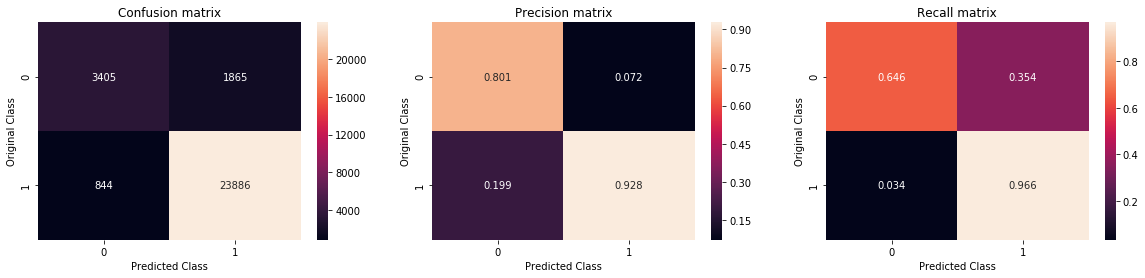

In [24]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

# OBSERVATION:
1) Using Grid Search Technique to find the best hyperparameter and regularizer technique(L1 or L2).
   The best C value is 10 and using L2 regularizer.
   
2) F1-micro-Score on test set: 91%


#### Sparsity increases with increase in lambda value in L1 regularization 

In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.667%
F1-Score on test set: 0.944
Non Zero weights: 1999


In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.667%
F1-Score on test set: 0.944
Non Zero weights: 1997


In [26]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.680%
F1-Score on test set: 0.945
Non Zero weights: 1987


In [27]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 50, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.697%
F1-Score on test set: 0.945
Non Zero weights: 1975


In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.820%
F1-Score on test set: 0.945
Non Zero weights: 1868


In [29]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.927%
F1-Score on test set: 0.946
Non Zero weights: 1734


In [30]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.927%
F1-Score on test set: 0.947
Non Zero weights: 1057


In [31]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.473%
F1-Score on test set: 0.934
Non Zero weights: 209


In [32]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.610%
F1-Score on test set: 0.905
Non Zero weights: 14


In [363]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.001, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.540%
F1-Score on test set: 0.904
Non Zero weights: 0


# OBSERVATION:
1) As lambda value increases in L1 regularizer (C=1/lambda, C is inversly propotional to Lambda so with increase in C value alpha value decreases) sparsity of the matrix also increase.

2) When C = 1000, Non Zero weights: 1999
   
   When C = 500, Non Zero weights: 1997
   
   When C = 100, Non Zero weights: 1987
   
   .                         .
   
   .                         .
   
   .                         .
   
   .                         .
   
   When C = 0.1, Non Zero weights: 14

**Random Search technique** to find the best c value and choosing between L1 and L2 regularizer

In [33]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1,scoring='f1_micro')
gsv.fit(x_train,y_train)
print("The best HyperParameter: ",gsv.best_params_)
print("The best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.0s finished


The best HyperParameter:  {'penalty': 'l1', 'C': 5}
The best Accuracy: 91.20%


Accuracy on test set: 90.923%
Precision on test set: 0.928
Recall on test set: 0.966
F1-micro-Score on test set: 0.909


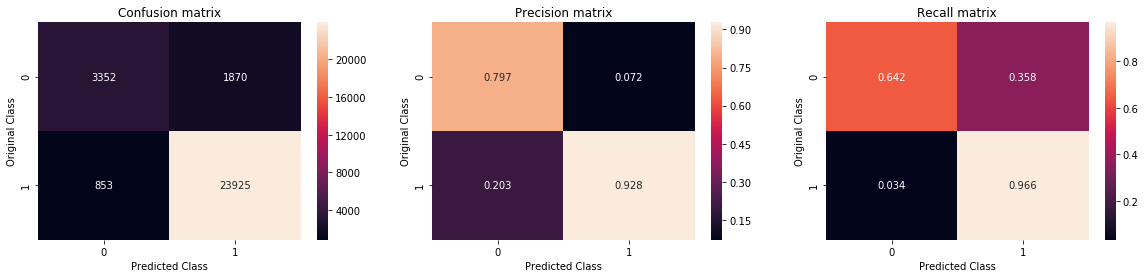

In [35]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

# OBSERVATION:
1) Using Random Search Technique to find the best hyperparameter and regularizer technique(L1 or L2).
   The best C value is 5 and using L1 regularizer.
   
2) F1-micro-Score on test set: 90.9%



#### To check if thr points are collineraity 

In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.910%
Non Zero weights: 2000


In [26]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 1.17472743  0.50390546 -1.19643661 -3.92259722  1.55617593 -0.84930903
  2.67959096  5.292382   -2.78604272 -2.63328675  0.29246723  0.04578861
  2.37473484  9.6910875   0.9703404   2.18245968  0.70171111  3.32130899
  3.94957755 -2.56238132 -5.34632198  0.25201655  9.00278645  0.85837007
  2.90038325 -2.7598946   2.3233266   3.72515501  2.46630748 -0.59899068
 -1.66688706  1.30755588  7.1172449  -3.15507067 -0.81272837  2.10498609
  1.12492679  1.20380242 -0.18995658 -2.49336188  4.67336831  3.28084982
  3.18014854 -0.25695403  0.63643132  1.44159048  0.83632304  2.97508518
  9.04415852  0.76129789]


In [27]:
x_train_n = x_train
#Random noise
noise = np.random.uniform(low=-0.0001, high=0.0001, size=(find(x_train_n)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(x_train_n)

#Introducing random noise to non-zero datapoints
x_train_n[a,b] = noise + x_train_n[a,b]

In [28]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(x_train_n,y_train)
y = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))


Accuracy on test set: 90.910%
Non Zero weights: 2000


In [29]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 1.20025694  0.53492983 -0.41562763 -3.1062348   0.9139054  -0.6893633
  1.69700798  3.64288356 -1.65371561 -1.75801095  0.27447176  0.09116646
  2.40452438  7.95302729  0.91127041  1.2108442   0.80475181  2.19782885
  2.83707059 -2.33300997 -3.61943997  0.07252493  5.76940968  0.64206276
  2.04713855 -2.70668313  1.08626399  2.38203399  1.70195632 -0.59559146
 -1.34821038  0.76947261  3.66562503 -2.35395973 -0.78073172  1.53115061
  0.9761756   0.83312282 -0.19551368 -2.23266163  3.4789186   2.59924946
  2.64050074 -0.19393007  0.68486383  1.0694115   0.70573797  2.82115462
  7.95480435  0.69697395]


In [30]:
print(weights2.size)

2000


In [31]:
#Add the small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
noise = 0.000001
weights1 = weights1 + noise
print(weights1[:25])

weights2 = weights2 + noise
print(weights2[:25])

[ 1.17472843  0.50390646 -1.19643561 -3.92259622  1.55617693 -0.84930803
  2.67959196  5.292383   -2.78604172 -2.63328575  0.29246823  0.04578961
  2.37473584  9.6910885   0.9703414   2.18246068  0.70171211  3.32130999
  3.94957855 -2.56238032 -5.34632098  0.25201755  9.00278745  0.85837107
  2.90038425]
[ 1.20025794  0.53493083 -0.41562663 -3.1062338   0.9139064  -0.6893623
  1.69700898  3.64288456 -1.65371461 -1.75800995  0.27447276  0.09116746
  2.40452538  7.95302829  0.91127141  1.2108452   0.80475281  2.19782985
  2.83707159 -2.33300897 -3.61943897  0.07252593  5.76941068  0.64206376
  2.04713955]


In [32]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [44]:
print(weights_diff[np.where(weights_diff > 0)].size)
print(weights_diff[np.where(weights_diff > 0.1)].size)
print(weights_diff[np.where(weights_diff > 0.2)].size)
print(weights_diff[np.where(weights_diff > 0.3)].size)
print(weights_diff[np.where(weights_diff > 0.4)].size)
print(weights_diff[np.where(weights_diff > 0.5)].size)
print(weights_diff[np.where(weights_diff > 0.6)].size)
print(weights_diff[np.where(weights_diff > 0.7)].size)
print(weights_diff[np.where(weights_diff > 0.8)].size)
print(weights_diff[np.where(weights_diff > 0.9)].size)
print(weights_diff[np.where(weights_diff > 1)].size)
print(weights_diff[np.where(weights_diff > 2)].size)
print(weights_diff[np.where(weights_diff > 3)].size)
print(weights_diff[np.where(weights_diff > 4)].size)
print(weights_diff[np.where(weights_diff > 5)].size)
print(weights_diff[np.where(weights_diff > 6)].size)
print(weights_diff[np.where(weights_diff > 7)].size)
print(weights_diff[np.where(weights_diff > 8)].size)
print(weights_diff[np.where(weights_diff > 9)].size)
print(weights_diff[np.where(weights_diff > 10)].size)
print(weights_diff[np.where(weights_diff > 20)].size)
print(weights_diff[np.where(weights_diff > 30)].size)
print(weights_diff[np.where(weights_diff > 40)].size)
print(weights_diff[np.where(weights_diff > 50)].size)
print(weights_diff[np.where(weights_diff > 60)].size)
print(weights_diff[np.where(weights_diff > 70)].size)
print(weights_diff[np.where(weights_diff > 80)].size)
print(weights_diff[np.where(weights_diff > 90)].size)
print(weights_diff[np.where(weights_diff > 100)].size)#228#202#197#162#108#56#
#24#29#26#19#16#25

1037
1035
1032
1031
1027
1026
1025
1023
1022
1017
1013
984
958
937
918
902
877
848
829
809
607
410
248
140
84
60
51
45
39


In [45]:
# feature names whose % change is more than a threshold x
df = pd.DataFrame(data=(abs(weights1 - weights2)/weights1) * 100 > 0.8, index=count_vect.get_feature_names())

In [46]:
df[df[0]] == True

,0
abl,True
absolut,True
accord,True
acquir,True
across,True
actual,True
ad,True
add,True
addict,True
addit,True


## Observation
 1022 feature's weight changes more than 0.8%. Hence, the feature are multi-collinear.

In [47]:
#top 50 important features for Positive and Negative features
def show_most_informative_features(vectorizer, clf, n=50):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegative\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,clf)

		Negative					Positive
________________________________________________________________________________________________
	-14.8650	worst          				9.8719	hook           
	-12.5189	aw             				9.8113	perfect        
	-10.6039	horribl        				9.4950	beat           
	-10.5643	wors           				9.4118	delici         
	-10.3681	terribl        				9.2373	skeptic        
	-9.8931	cancel         				8.8534	excel          
	-9.6892	disgust        				8.3560	fantast        
	-9.5487	tasteless      				7.9548	amaz           
	-9.0479	refund         				7.9530	addict         
	-8.8326	return         				7.9088	awesom         
	-8.5948	disappoint     				7.8655	yum            
	-8.5012	ruin           				7.7536	best           
	-8.3729	rancid         				7.2083	worri          
	-8.2106	shame          				7.1154	refresh        
	-8.1604	unpleas        				7.0236	hesit          
	-8.1189	bland          				7.0185	yummi          
	-7.8414	threw          				6.9951	everyday       
	-7.776

### Bi-Gram

In [48]:
# Spliting into Train and test
x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)


count_vect = CountVectorizer(max_features=2000,min_df=20,ngram_range=(1,2)) 

x_train = count_vect.fit_transform(x_train)
x_test = count_vect.transform(x_test)


#Normalize train and test data
x_train = preprocessing.normalize(x_train)
print("Train Data Size: ",x_train.shape)
x_test = preprocessing.normalize(x_test)
print("Test Data Size: ",x_test.shape)

Train Data Size:  (70000, 2000)
Test Data Size:  (30000, 2000)


**Grid Search technique** to find the best c value and choosing between L1 and L2 regularizer

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1, n_jobs=-1,scoring='f1_micro')
gsv.fit(x_train,y_train)
print("The best HyperParameter: ",gsv.best_params_)
print("The best Accuracy: %.2f%%"%(gsv.best_score_*100))



Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


The best HyperParameter:  {'C': 10, 'penalty': 'l2'}
The best Accuracy: 91.41%


Accuracy on test set: 91.190%
Precision on test set: 0.929
Recall on test set: 0.966
F1-micro-Score on test set: 0.912


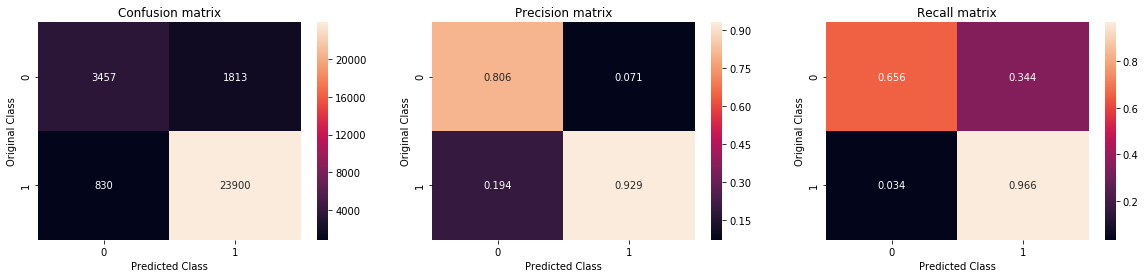

In [50]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

# OBSERVATION:
1) Using Grid Search Technique to find the best hyperparameter and regularizer technique(L1 or L2).
   The best C value is 10 and using L2 regularizer.
   
2) F1-micro-Score on test set: 91.2%

#### Sparsity increases with increase in lambda value in L1 regularization 

In [51]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.023%
F1-Score on test set: 0.946
Non Zero weights: 2000


In [52]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.020%
F1-Score on test set: 0.946
Non Zero weights: 1998


In [53]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.043%
F1-Score on test set: 0.947
Non Zero weights: 1989


In [54]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 50, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.047%
F1-Score on test set: 0.947
Non Zero weights: 1980


In [55]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.073%
F1-Score on test set: 0.947
Non Zero weights: 1889


In [56]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.160%
F1-Score on test set: 0.947
Non Zero weights: 1758


In [57]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.033%
F1-Score on test set: 0.947
Non Zero weights: 1105


In [58]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.520%
F1-Score on test set: 0.934
Non Zero weights: 213


In [59]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.477%
F1-Score on test set: 0.904
Non Zero weights: 12


# OBSERVATION:
1) As lambda value increases in L1 regularizer (C=1/lambda, C is inversly propotional to Lambda so with increase in       
   C value alpha value decreases) sparsity of the matrix also increase.

2) When C = 1000, Non Zero weights: 2000
      
   When C = 500, Non Zero weights: 1998
      
   When C = 100, Non Zero weights: 1989
      
   . .
      
   . .
      
   . .
      
   . .
      
   When C = 0.01, Non Zero weights: 12


**Random Search technique** to find the best c value and choosing between L1 and L2 regularizer

In [60]:
 %time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1,scoring='f1_micro')
gsv.fit(x_train,y_train)
print("The best HyperParameter: ",gsv.best_params_)
print("The best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.9s finished


The best HyperParameter:  {'penalty': 'l2', 'C': 10}
The best Accuracy: 91.41%


Accuracy on test set: 91.113%
Precision on test set: 0.927
Recall on test set: 0.968
F1-micro-Score on test set: 0.911


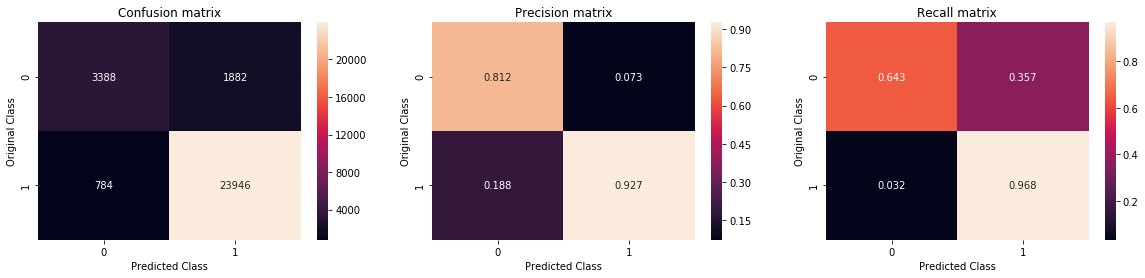

In [61]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

# OBSERVATION:
1) Using Random Search Technique to find the best hyperparameter and regularizer technique(L1 or L2). The best C value 

   is 10 and using L2 regularizer.

2) F1-micro-Score on test set: 91.1%

##### Finding if the features are Multi-collinear ? 

In [65]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.050%
Non Zero weights: 2000


In [66]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])


[ 1.24185971  0.45280111 -0.06976876  0.25426817  4.48568523 -4.71095516
  0.7604308  -0.13753954  5.50078729 -2.6172214   0.08094947  2.43481778
  0.38848867 -1.59409202  2.4167339   3.57289665  4.81471205  9.74052304
  1.37947298  0.73465091  1.14178569  3.94562584 -2.61761703 -0.75797448
  8.28441973  2.61758931 -3.652746    2.8378592   2.20436146 -2.05095151
 -1.26362457  1.50512969 -3.3048419  -0.30376877  2.44943525  1.21645134
  1.25049162 -0.12518926 -2.19589411  4.39037336  3.30533444  2.66651123
 -0.51173027 -0.01940582  6.66009577 12.38242422  9.0459184   0.42936282
  7.7300511  -6.19465756]


In [68]:
x_train_n = x_train
#Random noise
noise = np.random.uniform(low=-0.0001, high=0.0001, size=(find(x_train_n)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(x_train_n)

#Introducing random noise to non-zero datapoints
x_train_n[a,b] = noise + x_train_n[a,b]

In [69]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(x_train_n,y_train)
y = clf.predict(x_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.050%
Non Zero weights: 2000


In [70]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 1.24412513  0.42793693  0.08872663  0.38676092  3.01847336 -3.53518029
  0.60116881 -0.32021159  3.68632139 -1.65677072  0.11114003  1.81120325
  0.30331653 -1.34208807  2.41191989  1.69369378  2.46183159  7.97306739
  1.16268877  0.58680757  1.03611659  2.79356741 -2.35821336 -0.39536936
  5.6044984   1.78850215 -3.38128478  2.13973052  1.6771443  -1.23393564
 -1.08359984  0.9863157  -2.43215204 -0.56768975  1.72564824  1.0989168
  0.89533644 -0.13909629 -2.06920686  3.28257263  2.66393815  2.25149219
 -0.33990223  0.28624111  3.26492156  3.75593208  5.48697392  0.23933054
  3.19291226 -3.65251912]


In [71]:
#Add the small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
noise = 0.000001
weights1 = weights1 + noise
print(weights1[:25])

weights2 = weights2 + noise
print(weights2[:25])

[ 1.24186071  0.45280211 -0.06976776  0.25426917  4.48568623 -4.71095416
  0.7604318  -0.13753854  5.50078829 -2.6172204   0.08095047  2.43481878
  0.38848967 -1.59409102  2.4167349   3.57289765  4.81471305  9.74052404
  1.37947398  0.73465191  1.14178669  3.94562684 -2.61761603 -0.75797348
  8.28442073]
[ 1.24412613  0.42793793  0.08872763  0.38676192  3.01847436 -3.53517929
  0.60116981 -0.32021059  3.68632239 -1.65676972  0.11114103  1.81120425
  0.30331753 -1.34208707  2.41192089  1.69369478  2.46183259  7.97306839
  1.16268977  0.58680857  1.03611759  2.79356841 -2.35821236 -0.39536836
  5.6044994 ]


In [72]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [79]:
print(weights_diff[np.where(weights_diff > 0)].size)
print(weights_diff[np.where(weights_diff > 10)].size)
print(weights_diff[np.where(weights_diff > 20)].size)
print(weights_diff[np.where(weights_diff > 30)].size)
print(weights_diff[np.where(weights_diff > 30.1)].size)
print(weights_diff[np.where(weights_diff > 30.2)].size)
print(weights_diff[np.where(weights_diff > 30.3)].size)
print(weights_diff[np.where(weights_diff > 30.4)].size)
print(weights_diff[np.where(weights_diff > 30.5)].size)
print(weights_diff[np.where(weights_diff > 30.6)].size)
print(weights_diff[np.where(weights_diff > 30.7)].size)
print(weights_diff[np.where(weights_diff > 30.8)].size)
print(weights_diff[np.where(weights_diff > 30.9)].size)
print(weights_diff[np.where(weights_diff > 31)].size)
print(weights_diff[np.where(weights_diff > 32)].size)
print(weights_diff[np.where(weights_diff > 33)].size)
print(weights_diff[np.where(weights_diff > 34)].size)
print(weights_diff[np.where(weights_diff > 35)].size)
print(weights_diff[np.where(weights_diff > 36)].size)
print(weights_diff[np.where(weights_diff > 37)].size)
print(weights_diff[np.where(weights_diff > 38)].size)
print(weights_diff[np.where(weights_diff > 39)].size)
print(weights_diff[np.where(weights_diff > 40)].size)
print(weights_diff[np.where(weights_diff > 50)].size)
print(weights_diff[np.where(weights_diff > 60)].size)
print(weights_diff[np.where(weights_diff > 70)].size)
print(weights_diff[np.where(weights_diff > 80)].size)
print(weights_diff[np.where(weights_diff > 90)].size)
print(weights_diff[np.where(weights_diff > 100)].size)#179#220#236#205#115#51#24#17#7#4

1099
920
700
464
463
462
460
458
458
454
449
449
449
448
419
396
377
354
337
322
292
278
259
146
95
71
54
47
43


In [80]:
# feature names whose % change is more than a threshold x
df = pd.DataFrame(data=(abs(weights1 - weights2)/weights1) * 100 > 30, index=count_vect.get_feature_names())

In [81]:
df[df[0]] == True

,0
absolut delici,True
absolut love,True
across,True
actual,True
add littl,True
add water,True
afford,True
afternoon,True
ahead,True
also good,True


## Observation
 464 feature's weight changes more than 30%. Hence, the feature are multi-collinear.

In [82]:
#top 50 features of Negative reviews and positive reviews
def show_most_informative_features(vectorizer, clf, n=50):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegative\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,clf)

		Negative					Positive
________________________________________________________________________________________________
	-14.9507	worst          				13.4936	high recommend 
	-12.4264	aw             				9.9588	hook           
	-11.0154	wont buy       				9.8030	skeptic        
	-10.3941	horribl        				9.6724	perfect        
	-10.3217	terribl        				9.4122	delici         
	-10.3070	wors           				8.9597	excel          
	-10.1643	disgust        				8.5156	pleasant surpris
	-10.0355	cancel         				8.3385	beat           
	-9.2977	tasteless      				8.0998	fantast        
	-8.8995	refund         				8.0928	awesom         
	-8.8861	return         				8.0873	amaz           
	-8.8645	ruin           				8.0816	even better    
	-8.5894	disappoint     				8.0030	well worth     
	-8.1546	threw          				7.9731	addict         
	-7.8460	bland          				7.7177	right amount   
	-7.6223	never buy      				7.5882	yum            
	-7.6148	earth best     				7.3246	worri          
	-

# TF-IDF

In [83]:
#TF-IDF
from sklearn.model_selection import train_test_split

# Spliting into Train and test
x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

In [84]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000, min_df=10) #Using bi-grams
x_train = tfidf.fit_transform(x_train)
#Normalize Data
x_train = preprocessing.normalize(x_train)
print("Train Data Size: ",x_train.shape)
x_test = tfidf.transform(x_test)
#Normalize Data
x_test = preprocessing.normalize(x_test)
print("Test Data Size: ",x_test.shape)

Train Data Size:  (70000, 2000)
Test Data Size:  (30000, 2000)


In [85]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1,scoring='f1_micro')
gsv.fit(x_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 11.9 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l2'}
Best Accuracy: 91.41%


Accuracy on test set: 91.187%
Precision on test set: 0.929
Recall on test set: 0.967
F1-micro-Score on test set: 0.912


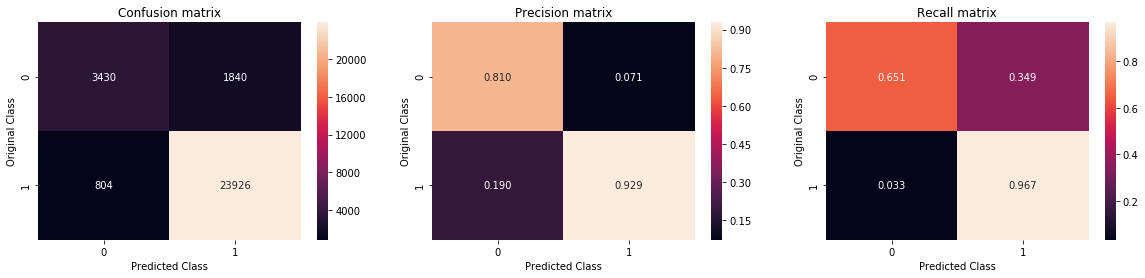

In [86]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

# OBSERVATION:
1) Using Grid Search Technique to find the best hyperparameter and regularizer technique(L1 or L2). The best C value
is 5 and using L2 regularizer.

2) F1-micro-Score on test set: 91.2%


In [87]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1,scoring='f1_micro')
gsv.fit(x_train,y_train)
print("The best HyperParameter: ",gsv.best_params_)
print("The best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.7s finished


The best HyperParameter:  {'penalty': 'l1', 'C': 5}
The best Accuracy: 91.31%


Accuracy on test set: 91.067%
Precision on test set: 0.930
Recall on test set: 0.964
F1-micro-Score on test set: 0.911


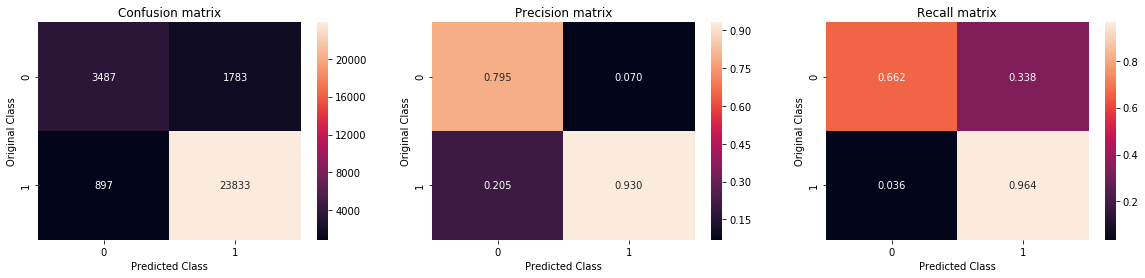

In [88]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(x_train,y_train)
pred = clf.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

# OBSERVATION:
1) Using Random Search Technique to find the best hyperparameter and regularizer technique(L1 or L2). The best C value
   is 5 and using L2 regularizer.

2) F1-micro-Score on test set: 91.1%

In [89]:
#Top 50 features of neaftive and positive reviews
def show_most_informative_features(vectorizer, clf, n=50):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegative\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,clf)

		Negative					Positive
________________________________________________________________________________________________
	-13.4235	wors           				18.5920	high recommend 
	-10.8019	aw             				18.5288	pleasant       
	-9.3281	wont           				15.2204	size           
	-9.1105	horribl        				12.9683	hook           
	-9.0595	disappoint     				12.5367	delici         
	-8.9397	tender         				12.2626	per serv       
	-8.7772	worri          				11.1542	great          
	-8.5985	disgust        				10.9585	best           
	-8.3780	cancel         				10.4406	excel          
	-8.0695	retail         				9.6461	right          
	-7.7709	tast wonder    				9.1108	well           
	-7.4741	refriger       				8.9925	yum            
	-7.4342	rub            				8.8238	beat           
	-7.0854	thought would  				8.6892	love           
	-6.8706	earth best     				8.5825	amaz           
	-6.7108	bland          				8.3827	awesom         
	-6.4163	understand     				8.2728	fantast        
	

## Word2Vec 

In [90]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [91]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

rememb see show air televis year ago child sister later bought day thirti someth use seri book song student teach preschool turn whole school purchas along book children tradit live
*****************************************************************
['rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'book', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school', 'purchas', 'along', 'book', 'children', 'tradit', 'live']


In [92]:
#min_count = 5 considers only words that occured atleast 5 times
w2v_model = Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [93]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])


number of words that occured minimum 5 times  12638
sample words  ['rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'book', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school', 'purchas', 'along', 'children', 'tradit', 'live', 'twist', 'captur', 'film', 'star', 'michael', 'keaton', 'geena', 'davi', 'prime', 'tim', 'burton', 'masterpiec', 'rumbl', 'absurd', 'wonder', 'pace', 'point', 'dull', 'moment', 'apart', 'infest']


# Average Word2Vec

In [94]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100000
50


In [95]:
from sklearn.model_selection import train_test_split

# Spliting into Train and test
x_train, x_test, y_train, y_test = train_test_split(sent_vectors, final['Score'].values, test_size=0.3, shuffle=False)


In [96]:
#Normalize Data
x_train = preprocessing.normalize(x_train)
print("Train Data Size: ",x_train.shape)
#Normalize Data
x_test = preprocessing.normalize(x_test)
print("Test Data Size: ",x_test.shape)

Train Data Size:  (70000, 50)
Test Data Size:  (30000, 50)


In [97]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1,scoring='f1_micro')
gsv.fit(x_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/rohitbohra/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/rohitbohra/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/rohitbohra/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", Use

Best HyperParameter:  {'C': 10, 'penalty': 'l1'}
Best Accuracy: 89.75%


/Users/rohitbohra/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy on test set: 88.570%
Precision on test set: 0.905
Recall on test set: 0.962
F1-micro-Score on test set: 0.886


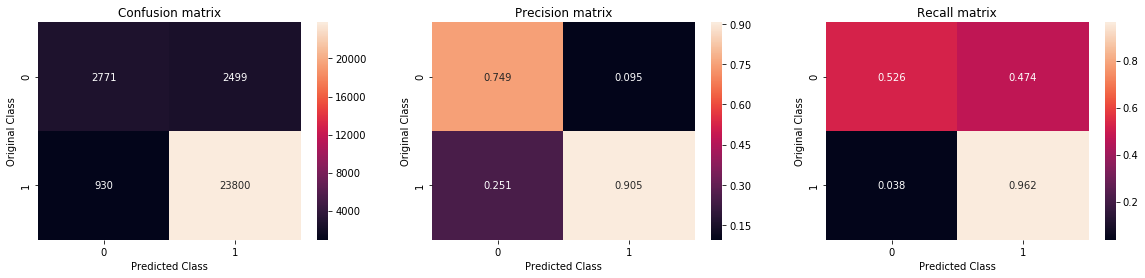

In [100]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1',max_iter=10)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

# OBSERVATION:
1) Using Grid Search Technique to find the best hyperparameter and regularizer technique(L1 or L2). The best C value
   is 10 and using L1 regularizer.

2) F1-micro-Score on test set: 88.6%



In [99]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1,scoring='f1_micro')
gsv.fit(x_train,y_train)
print("The best HyperParameter: ",gsv.best_params_)
print("The best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.9 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.1s finished


The best HyperParameter:  {'penalty': 'l2', 'C': 50}
The best Accuracy: 89.74%


Accuracy on test set: 88.530%
Precision on test set: 0.905
Recall on test set: 0.962
F1-micro-Score on test set: 0.885


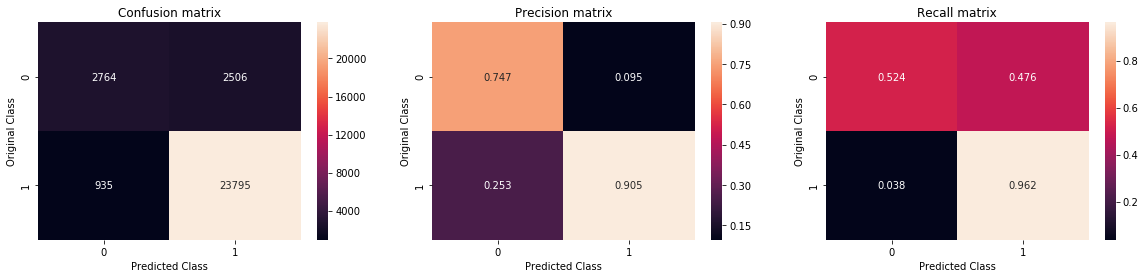

In [101]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l2',max_iter=100)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

# OBSERVATION:
1) Using Random Search Technique to find the best hyperparameter and regularizer technique(L1 or L2). The best C value
   is 50 and using L2 regularizer.

2) F1-micro-Score on test set: 88.5%

# TF-IDF Weighted Word2Vec

In [102]:
model=TfidfVectorizer()
tf_idf_matrix=model.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(tf_idf_matrix))
print("the shape of out text TFIDF vectorizer ",tf_idf_matrix.get_shape())
print("the number of unique words including both unigrams and bigrams ", tf_idf_matrix.get_shape()[1])
dictionary=dict(zip(model.get_feature_names(),list(model.idf_)))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (100000, 37860)
the number of unique words including both unigrams and bigrams  37860


In [103]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 100000/100000 [04:32<00:00, 366.41it/s]


In [104]:
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

100000
50


In [105]:
from sklearn.model_selection import train_test_split

# Spliting into Train and test
x_train, x_test, y_train, y_test = train_test_split(tfidf_sent_vectors, final['Score'].values, test_size=0.3, shuffle=False)

In [106]:
#Normalize Data
x_train = preprocessing.normalize(x_train)
print("Train Data Size: ",x_train.shape)
#Normalize Data
x_test = preprocessing.normalize(x_test)
print("Test Data Size: ",x_test.shape)

Train Data Size:  (70000, 50)
Test Data Size:  (30000, 50)


In [107]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1,scoring='f1_micro')
gsv.fit(x_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.4min finished


Best HyperParameter:  {'C': 500, 'penalty': 'l1'}
Best Accuracy: 88.34%


Accuracy on test set: 86.960%
Precision on test set: 0.888
Recall on test set: 0.964
F1-micro-Score on test set: 0.870


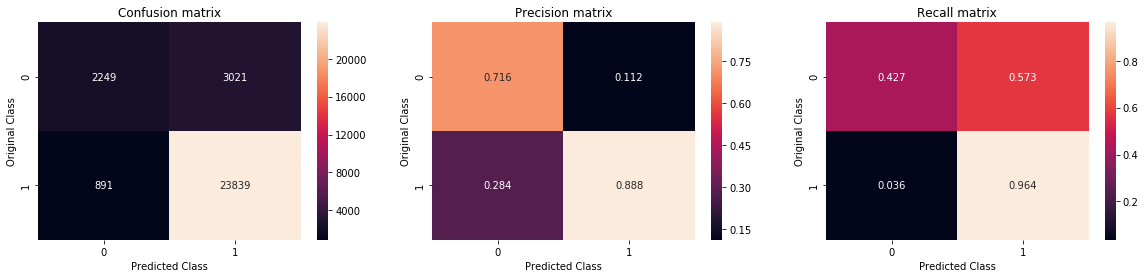

In [108]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l1',max_iter=100)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

# OBSERVATION:
1) Using Grid Search Technique to find the best hyperparameter and regularizer technique(L1 or L2). The best C value
   is 500 and using L1 regularizer.

2) F1-micro-Score on test set: 87%



In [109]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,n_jobs=-1,scoring='f1_micro')
gsv.fit(x_train,y_train)
print("The best HyperParameter: ",gsv.best_params_)
print("The best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 13.8 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


The best HyperParameter:  {'penalty': 'l1', 'C': 500}
The best Accuracy: 88.34%


Accuracy on test set: 86.953%
Precision on test set: 0.887
Recall on test set: 0.964
F1-micro-Score on test set: 0.870


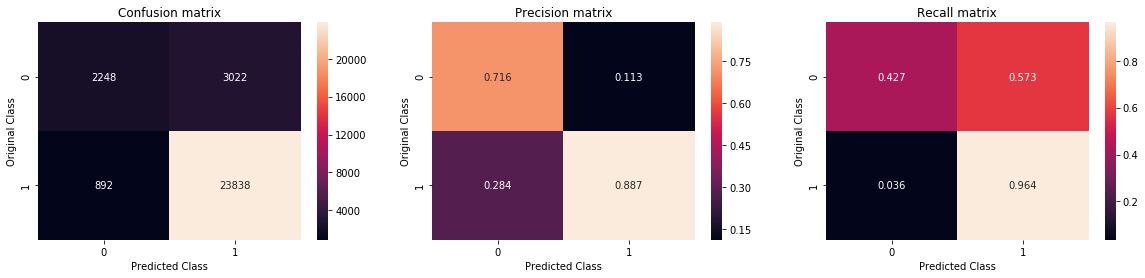

In [110]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l1',max_iter=100)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-micro-Score on test set: %0.3f"%(f1_score(y_test, pred,average='micro')))
plot_confusion_matrix(y_test, pred)

# OBSERVATION:
1) Using Grid Search Technique to find the best hyperparameter and regularizer technique(L1 or L2). The best C value
   is 500 and using L1 regularizer.

2) F1-micro-Score on test set: 87%



In [116]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Featurization", "Search Technique", "C=1/Lambda","Regularization", "F1-Score", "Accuracy"]
 
x.add_row(["BOW(uni-gram)", "Grid Search", 10, "L2",91, 90.97]) 
x.add_row(["BOW(uni-gram)", "Random Search", 5, "L1", 90.9, 90.92]) 
x.add_row(["BOW(bi-gram)", "Grid Search", 10, "L2",91.2, 91.19]) 
x.add_row(["BOW(bi-gram)", "Random Search", 10, "L2", 91.11, 91.11]) 
x.add_row(["TF_IDF", "Grid Search", 5, "L2", 91.1, 91.18]) 
x.add_row(["TF_IDF", "Random Search", 10, "L2", 91.1, 91.06])
x.add_row(["Avg W2V", "Grid Search", 10, "L1", 88.6, 88.57]) 
x.add_row(["Avg W2V", "Random Search", 500, "L2",  88.5, 88.53])
x.add_row(["TFIDF W2V", "Grid Search", 500, "L1", 87.0, 86.96]) 
x.add_row(["TFIDF W2V", "Random Search", 500, "L1", 87, 86.95])
print("\t\t\t\tLOGISTIC REGRESSION")
print(x)

				LOGISTIC REGRESSION
+---------------+------------------+------------+----------------+----------+----------+
| Featurization | Search Technique | C=1/Lambda | Regularization | F1-Score | Accuracy |
+---------------+------------------+------------+----------------+----------+----------+
| BOW(uni-gram) |   Grid Search    |     10     |       L2       |    91    |  90.97   |
| BOW(uni-gram) |  Random Search   |     5      |       L1       |   90.9   |  90.92   |
|  BOW(bi-gram) |   Grid Search    |     10     |       L2       |   91.2   |  91.19   |
|  BOW(bi-gram) |  Random Search   |     10     |       L2       |  91.11   |  91.11   |
|     TF_IDF    |   Grid Search    |     5      |       L2       |   91.1   |  91.18   |
|     TF_IDF    |  Random Search   |     10     |       L2       |   91.1   |  91.06   |
|    Avg W2V    |   Grid Search    |     10     |       L1       |   88.6   |  88.57   |
|    Avg W2V    |  Random Search   |    500     |       L2       |   88.5   |  88.53  

# Final Observation

1) The best F1-Score is 91.2% 

2) The best F1-Score was found to be on Bag Of Words(Bi-Gram).

3) The best accuracy was found to be 91.19% for Bag Of Words.

4) Sparsity of the matrix increases with decrease in C (increase in lambda). 

5) The features are multi-collinear.
